# Exercise 5

A pencil producer performs a process control by using 3 quality characteristics:
1. Pencil diameter
2. Ultimate tensile strength
3. The ease of sliding on paper (glide)  

Data referring to 20 samples of size $n=3$ are reported in the file `ESE8_ex5.csv`.

Design an Hotelling $T^2$ control chart. 

> ### Solution

In [1]:
# Import the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd

# Import the data
data = pd.read_csv('ESE8_ex5.csv')

# Inspect the data
data.head()

,Sample,Diameter 1,Diameter 2,Diameter 3,Tensile strength 1,Tensile strength 2,Tensile strength 3,Glide 1,Glide 2,Glide 3
0,1,2.3,-0.1,-1.4,3.48,2.72,2.28,5.85,5.53,4.46
1,2,-1.7,0.0,0.1,2.19,2.90,2.74,4.25,5.51,4.24
2,3,0.4,-0.1,0.4,2.89,2.81,3.24,6.83,5.01,4.65
3,4,-0.6,0.5,-0.7,2.66,2.98,2.51,6.00,6.40,4.47
4,5,0.2,0.4,-0.9,2.76,2.52,2.69,4.60,4.70,5.55


> First of all we check the Marginal Normality

Shapiro-Wilk test on Diameter p-value = 0.348


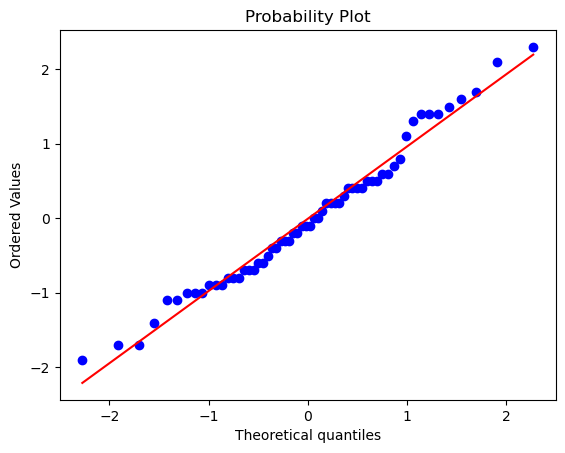

In [2]:
diameter = data[['Diameter 1', 'Diameter 2', 'Diameter 3']]

# Perform the Shapiro-Wilk test on the Diameter
_, pval1_SW = stats.shapiro(diameter)
print('Shapiro-Wilk test on Diameter p-value = %.3f' % pval1_SW)

# Plot the qqplot
stats.probplot(diameter.stack(), dist="norm", plot=plt)
plt.show()

Shapiro-Wilk test on Tensile strenght p-value = 0.433


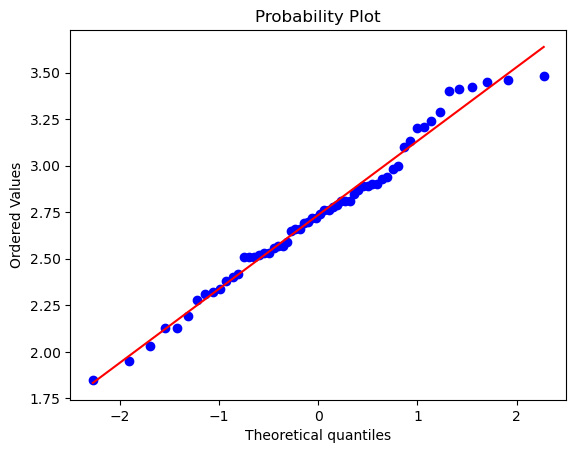

In [3]:
uts = data[['Tensile strength 1', 'Tensile strength 2', 'Tensile strength 3']]

# Perform the Shapiro-Wilk test on the Tensile strength
_, pval2_SW = stats.shapiro(uts)
print('Shapiro-Wilk test on Tensile strenght p-value = %.3f' % pval2_SW)

# Plot the qqplot
stats.probplot(uts.stack(), dist="norm", plot=plt)
plt.show()

Shapiro-Wilk test on Glide p-value = 0.352


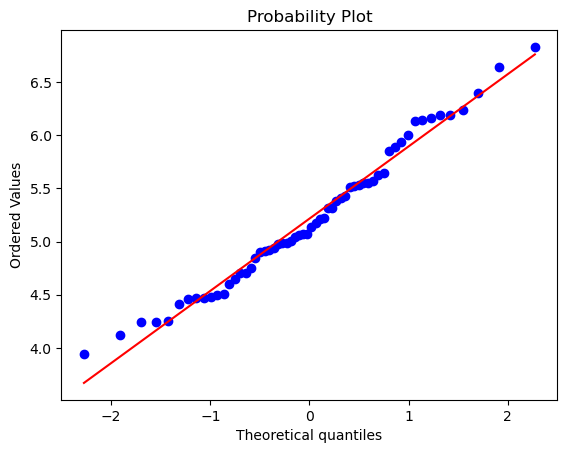

In [4]:
glide = data[['Glide 1', 'Glide 2', 'Glide 3']]

# Perform the Shapiro-Wilk test on the Glide
_, pval3_SW = stats.shapiro(glide)
print('Shapiro-Wilk test on Glide p-value = %.3f' % pval3_SW)

# Plot the qqplot
stats.probplot(glide.stack(), dist="norm", plot=plt)
plt.show()

In [5]:
# Create a new dataframe to store the sample mean
sample_mean = pd.DataFrame()
sample_mean['diameter'] = diameter.mean(axis=1)
sample_mean['uts'] = uts.mean(axis=1)
sample_mean['glide'] = glide.mean(axis=1)

# Calculate the grand mean
Xbarbar = sample_mean.mean()
print(Xbarbar)

diameter   -0.006667
uts         2.735500
glide       5.215333
dtype: float64


In [6]:
# Create a new dataframe to store the stacked data
data_stack = pd.DataFrame()
data_stack[['sample', 'diameter']] = diameter.transpose().melt()
data_stack['uts'] = uts.transpose().melt()['value']
data_stack['glide'] = glide.transpose().melt()['value']

data_stack.head(9)

,sample,diameter,uts,glide
0,0,2.3,3.48,5.85
1,0,-0.1,2.72,5.53
2,0,-1.4,2.28,4.46
3,1,-1.7,2.19,4.25
4,1,0.0,2.90,5.51
5,1,0.1,2.74,4.24
6,2,0.4,2.89,6.83
7,2,-0.1,2.81,5.01
8,2,0.4,3.24,4.65


In [7]:
# Compute the variance and covariance matrix of each group (sample)
cov_matrix = data_stack.groupby('sample').cov()

cov_matrix.head(9)

diameter       uts     glide
sample                                       
0      diameter  3.523333  1.139333  1.217000
       uts       1.139333  0.368533  0.397000
       glide     1.217000  0.397000  0.529900
1      diameter  1.023333  0.363500  0.332833
       uts       0.363500  0.138700  0.182050
       glide     0.332833  0.182050  0.533433
2      diameter  0.083333  0.042500  0.121667
       uts       0.042500  0.052300 -0.128700
       glide     0.121667 -0.128700  1.365733

In [8]:
# Compute the mean covariance matrix
S = cov_matrix.groupby(level=1).mean()

print(S)

          diameter       uts     glide
diameter  0.910167  0.229467  0.271600
glide     0.271600  0.138368  0.473593
uts       0.229467  0.134328  0.138368


> Attention! The indeces are now in alphabetic order. We need to reorder them in the order of the variables to get the correct variance/covariance matrix.

In [9]:
# Reorder the indeces of S to match the order of the columns
# get the names of the columns
cols = S.columns.tolist()

S = S.reindex(columns=cols, index=cols)

print(S)

          diameter       uts     glide
diameter  0.910167  0.229467  0.271600
uts       0.229467  0.134328  0.138368
glide     0.271600  0.138368  0.473593


> Now we can compute the T<sup>2</sup> Control Chart

In [10]:
p = 3           # number of random variables
m = len(data)   # number of samples
n = 3           # number of replicates (sample size)
alpha = 0.0027  # significance level

S_inv = np.linalg.inv(S)

# Create a new dataframe to store the T2 statistics
data_CC = sample_mean.copy()
data_CC['T2'] = np.nan

for i in range(m):
    data_CC['T2'].iloc[i] = n * (sample_mean.iloc[i] - Xbarbar).transpose().dot(S_inv).dot(sample_mean.iloc[i] - Xbarbar)

# Now we can add the UCL, CL and LCL to the dataframe
data_CC['T2_UCL'] = (p*(m-1)*(n-1))/(m*(n-1)-(p-1))*stats.f.ppf(1-alpha, p, m*n-m+1-p)
data_CC['T2_CL'] = data_CC['T2'].median()
data_CC['T2_LCL'] = 0

# Add one column to test if the sample is out of control
data_CC['T2_TEST'] = np.where((data_CC['T2'] > data_CC['T2_UCL']), data_CC['T2'], np.nan)

# Inspect the dataset
data_CC.head()

,diameter,uts,glide,T2,T2_UCL,T2_CL,T2_LCL,T2_TEST
0,0.266667,2.826667,5.280000,0.278341,16.898109,2.09881,0,NaN
1,-0.533333,2.610000,4.666667,2.363377,16.898109,2.09881,0,NaN
2,0.233333,2.980000,5.496667,1.533608,16.898109,2.09881,0,NaN
3,-0.266667,2.716667,5.623333,2.098853,16.898109,2.09881,0,NaN
4,-0.100000,2.656667,4.950000,0.467668,16.898109,2.09881,0,NaN


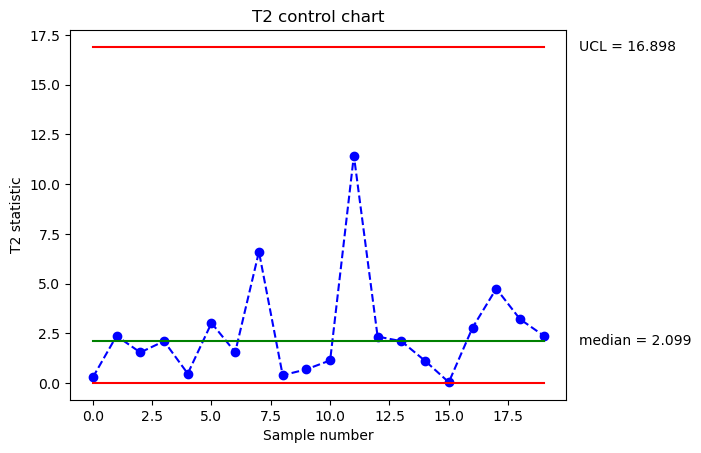

In [11]:
# Plot the T2 control chart
plt.title('T2 control chart')
plt.plot(data_CC['T2'], color='b', linestyle='--', marker='o')
plt.plot(data_CC['T2_UCL'], color='r')
plt.plot(data_CC['T2_CL'], color='g')
plt.plot(data_CC['T2_LCL'], color='r')
plt.ylabel('T2 statistic')
plt.xlabel('Sample number')
# add the values of the control limits on the right side of the plot
plt.text(len(data_CC)+.5, data_CC['T2_UCL'].iloc[0], 'UCL = {:.3f}'.format(data_CC['T2_UCL'].iloc[0]), verticalalignment='center')
plt.text(len(data_CC)+.5, data_CC['T2_CL'].iloc[0], 'median = {:.3f}'.format(data_CC['T2_CL'].iloc[0]), verticalalignment='center')
# highlight the points that violate the alarm rules
plt.plot(data_CC['T2_TEST'], linestyle='none', marker='s', color='r', markersize=10)
plt.show()